In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/AI/.kaggle/"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/AI/.kaggle

/content/drive/MyDrive/AI/.kaggle


In [ ]:
!kaggle datasets download -d jangedoo/utkface-new

 95% 316M/331M [00:02<00:00, 70.3MB/s]
100% 331M/331M [00:02<00:00, 128MB/s] 


In [ ]:
!unzip utkface-new.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: utkface_aligned_cropped/crop_part1/34_1_0_20170109004755204.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_0_20170111182452832.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170103230340961.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170104011329697.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170104165020320.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170108230211421.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104022134829.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104023010725.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104172537171.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104201443273.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104204327523.jpg.chip.jp

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os

In [ ]:
path = "/content/drive/MyDrive/AI/.kaggle/UTKFace/"
files = os.listdir(path)
size = len(files)
print("Total samples:",size)
print(files[0])

Total samples: 23708
100_0_0_20170112213500903.jpg.chip.jpg


In [ ]:
import cv2
images = []
ages = []
genders = []
for file in files:
    image = cv2.imread(path+file,0)
    image = cv2.resize(image,dsize=(64,64))
    image = image.reshape((image.shape[0],image.shape[1],1))
    images.append(image)
    split_var = file.split('_')
    ages.append(split_var[0])
    genders.append(int(split_var[1]) )

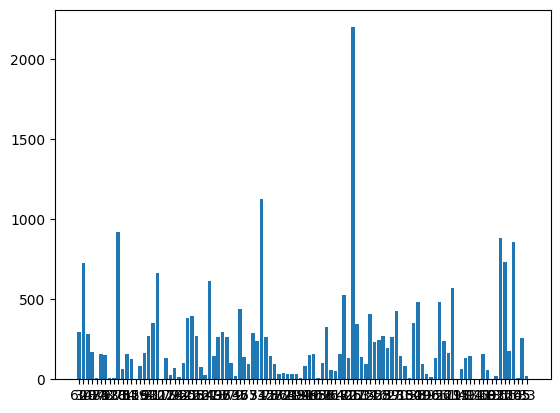

Max value: 99


In [ ]:
import matplotlib.pyplot as plt
x_ages = list(set(ages))
y_ages = [ages.count(i) for i in x_ages]
plt.bar(x_ages,y_ages)
plt.show()
print("Max value:",max(ages))

Gender: Female  Age: 14


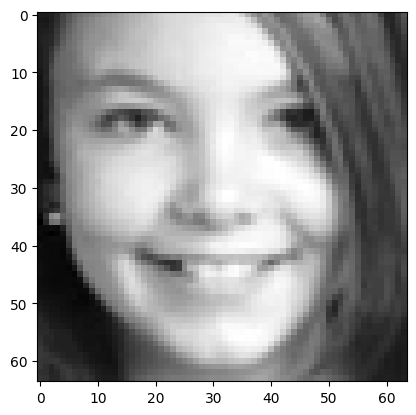

In [ ]:
def display(img):
    plt.imshow(img[:,:,0])
    plt.set_cmap('gray')
    plt.show()
idx = 550
sample = images[idx]
if genders[idx] == 0:
  print("Gender: Male ","Age:",ages[idx])
else:
  print("Gender: Female ","Age:",ages[idx])
display(sample)

In [ ]:
def age_group(age):
    if age >=0 and age < 18:
        return 1
    elif age < 30:
        return 2
    elif age < 80:
        return 3
    else:
        return 4

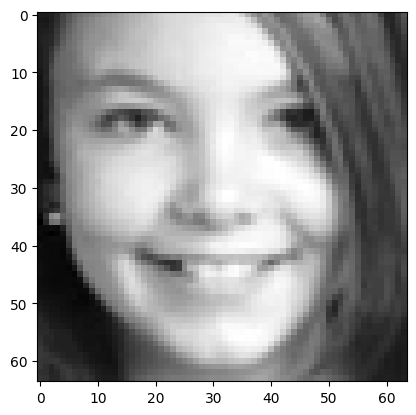

In [ ]:
# pre processing
target = np.zeros((size,2),dtype='float32')
features = np.zeros((size,sample.shape[0],sample.shape[1],1),dtype = 'float32')
for i in range(size):
    target[i,0] = age_group(int(ages[i])) / 4
    target[i,1] = int(genders[i])
    features[i] = images[i]
features = features / 255
display(features[550])

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2,shuffle  = True)
print("Samples in Training:",x_train.shape[0])
print("Samples in Testing:",x_test.shape[0])

Samples in Training: 18966
Samples in Testing: 4742


In [ ]:
print("Shape of image:",sample.shape)

Shape of image: (64, 64, 1)


In [ ]:
import keras 
from keras.layers import *
from keras.models import *
from keras import backend as K

In [ ]:
inputs = Input(shape=(64,64,1))
conv1 = Conv2D(32, kernel_size=(3, 3),activation='relu')(inputs)
conv2 = Conv2D(64, kernel_size=(3, 3),activation='relu')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(128, kernel_size=(3, 3),activation='relu')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv3)
x = Dropout(0.25)(pool2)
flat = Flatten()(x)

dropout = Dropout(0.5)
age_model = Dense(128, activation='relu')(flat)
age_model = dropout(age_model)
age_model = Dense(64, activation='relu')(age_model)
age_model = dropout(age_model)
age_model = Dense(32, activation='relu')(age_model)
age_model = dropout(age_model)
age_model = Dense(1, activation='relu')(age_model)

dropout = Dropout(0.5)
gender_model = Dense(128, activation='relu')(flat)
gender_model = dropout(gender_model)
gender_model = Dense(64, activation='relu')(gender_model)
gender_model = dropout(gender_model)
gender_model = Dense(32, activation='relu')(gender_model)
gender_model = dropout(gender_model)
gender_model = Dense(16, activation='relu')(gender_model)
gender_model = dropout(gender_model)
gender_model = Dense(8, activation='relu')(gender_model)
gender_model = dropout(gender_model)
gender_model = Dense(1, activation='sigmoid')(gender_model)

In [ ]:
model = Model(inputs=inputs, outputs=[age_model,gender_model])
model.compile(optimizer = 'adam', loss =['mse','binary_crossentropy'],metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 62, 62, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 60, 60, 64)   18496       ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 30, 30, 64)   0           ['conv2d_1[0][0]']               
                                                                                              

In [ ]:
h = model.fit(x_train,[y_train[:,0],y_train[:,1]],validation_data=(x_test,[y_test[:,0],y_test[:,1]]),epochs = 25, batch_size=128,shuffle = True)

Epoch 1/25
149/149 [==============================] - 24s 54ms/step - loss: 0.8318 - dense_3_loss: 0.1383 - dense_9_loss: 0.6935 - dense_3_accuracy: 0.0106 - dense_9_accuracy: 0.5177 - val_loss: 0.7351 - val_dense_3_loss: 0.0435 - val_dense_9_loss: 0.6917 - val_dense_3_accuracy: 0.0188 - val_dense_9_accuracy: 0.5209
Epoch 2/25
149/149 [==============================] - 8s 53ms/step - loss: 0.7308 - dense_3_loss: 0.0512 - dense_9_loss: 0.6796 - dense_3_accuracy: 0.0194 - dense_9_accuracy: 0.5136 - val_loss: 0.6350 - val_dense_3_loss: 0.0315 - val_dense_9_loss: 0.6035 - val_dense_3_accuracy: 0.0268 - val_dense_9_accuracy: 0.5209
Epoch 3/25
149/149 [==============================] - 7s 50ms/step - loss: 0.6507 - dense_3_loss: 0.0449 - dense_9_loss: 0.6058 - dense_3_accuracy: 0.0213 - dense_9_accuracy: 0.6852 - val_loss: 0.5554 - val_dense_3_loss: 0.0283 - val_dense_9_loss: 0.5270 - val_dense_3_accuracy: 0.0304 - val_dense_9_accuracy: 0.7990
Epoch 4/25
149/149 [============================

In [ ]:
# model.save('data.h5')

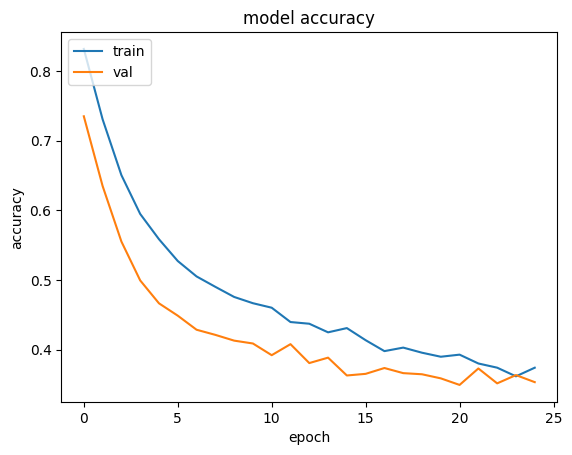

In [ ]:
history = h
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
def display(img):
    plt.imshow(img[:,:,0])
    plt.set_cmap('gray')
    plt.show()
    
def age_group(age):
    if age >=0 and age < 18:
        return 1
    elif age < 30:
        return 2
    elif age < 80:
        return 3
    else:
        return 4

def get_age(distr):
    distr = distr*4
    if distr >= 0.65 and distr <= 1.4:return "0-18"
    if distr >= 1.65 and distr <= 2.4:return "19-30"
    if distr >= 2.65 and distr <= 3.4:return "31-80"
    if distr >= 3.65 and distr <= 4.4:return "80 +"
    return "Unknown"
    
def get_gender(prob):
    if prob < 0.5:return "Male"
    else: return "Female"

def get_result(sample):
    sample = sample/255
    val = model.predict( np.array([ sample ]) )    
    age = get_age(val[0])
    gender = get_gender(val[1])
    print("Values:",val,"\nPredicted Gender:",gender,"Predicted Age:",age)

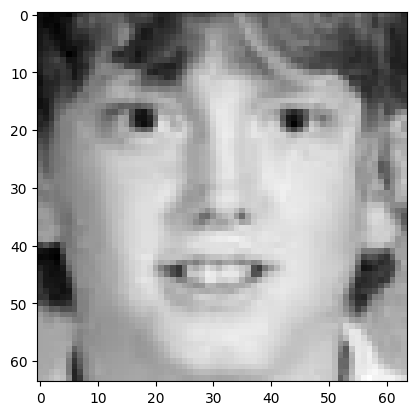

Actual Gender: Male Age: 14
1/1 [==============================] - 0s 237ms/step
Values: [array([[0.43518296]], dtype=float32), array([[0.7994532]], dtype=float32)] 
Predicted Gender: Female Predicted Age: 19-30


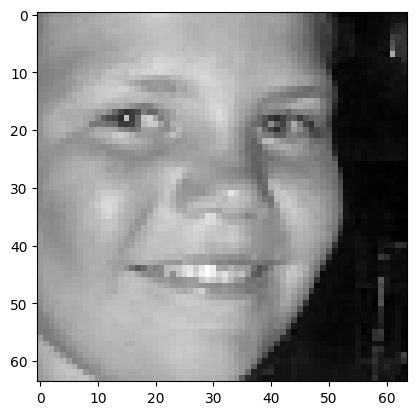

Actual Gender: Male Age: 10
1/1 [==============================] - 0s 24ms/step
Values: [array([[0.45794156]], dtype=float32), array([[0.7134639]], dtype=float32)] 
Predicted Gender: Female Predicted Age: 19-30


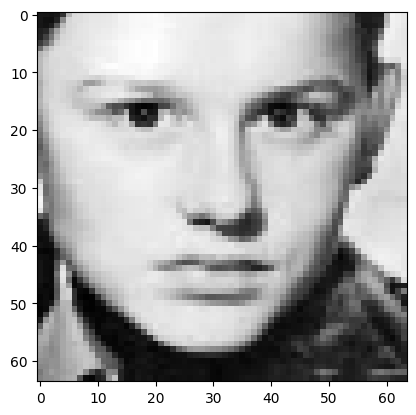

Actual Gender: Male Age: 10
1/1 [==============================] - 0s 20ms/step
Values: [array([[0.44238585]], dtype=float32), array([[0.22410196]], dtype=float32)] 
Predicted Gender: Male Predicted Age: 19-30


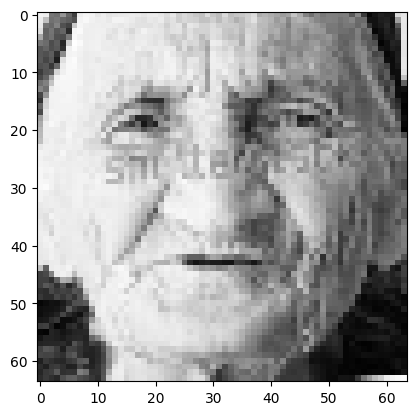

Actual Gender: Female Age: 100
1/1 [==============================] - 0s 23ms/step
Values: [array([[0.7240144]], dtype=float32), array([[0.70714545]], dtype=float32)] 
Predicted Gender: Female Predicted Age: 31-80


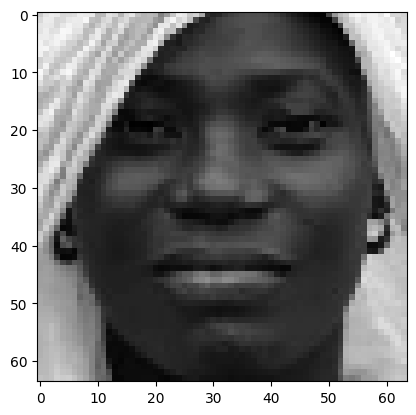

Actual Gender: Female Age: 24
1/1 [==============================] - 0s 21ms/step
Values: [array([[0.65714335]], dtype=float32), array([[0.7994532]], dtype=float32)] 
Predicted Gender: Female Predicted Age: Unknown


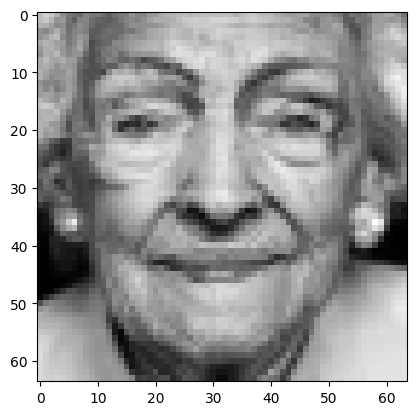

Actual Gender: Female Age: 100
1/1 [==============================] - 0s 20ms/step
Values: [array([[0.7407788]], dtype=float32), array([[0.7994532]], dtype=float32)] 
Predicted Gender: Female Predicted Age: 31-80


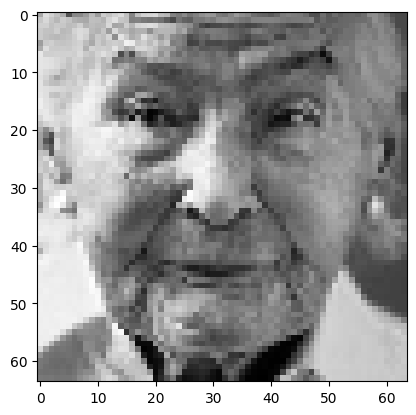

Actual Gender: Female Age: 100
1/1 [==============================] - 0s 20ms/step
Values: [array([[0.736267]], dtype=float32), array([[0.05502282]], dtype=float32)] 
Predicted Gender: Male Predicted Age: 31-80


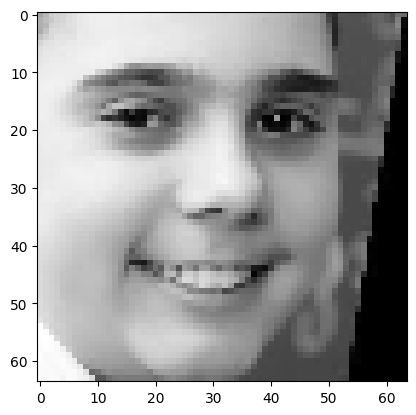

Actual Gender: Male Age: 12
1/1 [==============================] - 0s 21ms/step
Values: [array([[0.42173594]], dtype=float32), array([[0.02925438]], dtype=float32)] 
Predicted Gender: Male Predicted Age: 19-30


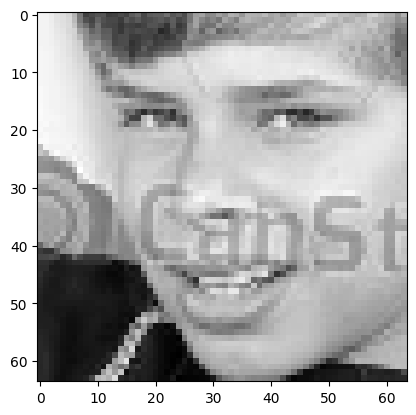

Actual Gender: Male Age: 10
1/1 [==============================] - 0s 20ms/step
Values: [array([[0.44405958]], dtype=float32), array([[0.10213114]], dtype=float32)] 
Predicted Gender: Male Predicted Age: 19-30


In [ ]:
indexes = [500,59,80,2,4546,7,9,256,45]
for idx in indexes:
    sample = images[idx]
    display(sample)
    print("Actual Gender:",get_gender(genders[idx]),"Age:",ages[idx])
    res = get_result(sample)